# Problema 3: Inferencia Bayesiana con Metropolis-Hastings


In [5]:
# Instalar y cargar librerías necesarias
if (!require(ggplot2)) install.packages("ggplot2")
if (!require(gridExtra)) install.packages("gridExtra")
if (!require(dplyr)) install.packages("dplyr")

library(ggplot2)
library(gridExtra)
library(dplyr)

## Parte 1: Simulación de datos de la mezcla

Simular 100 observaciones de:
$$(1 - \alpha) \cdot \mathcal{N}(8, 5^2) + \alpha \cdot t_3(10)$$
donde $\alpha = 0.7$


In [6]:
# Parámetros de la mezcla
alpha_verdadero <- 0.7
n <- 100

# Función para simular de la mezcla
simular_mezcla <- function(n, alpha) {
    # Vector para almacenar las muestras
    muestras <- numeric(n)

    for (i in 1:n) {
        # Decidir de qué componente muestrear
        u <- runif(1)
        if (u > alpha) {
            # Componente normal
            muestras[i] <- rnorm(1, mean = 8, sd = 5)
        } else {
            # Componente t-student
            # t-student con localización 10 y 3 grados de libertad
            muestras[i] <- 10 + rt(1, df = 3)
        }
    }
    return(muestras)
}

# Simular los datos
datos <- simular_mezcla(n, alpha_verdadero)

cat("Datos simulados:\n")
cat("Media muestral:", mean(datos), "\n")
cat("Desviación estándar muestral:", sd(datos), "\n")
cat("Mínimo:", min(datos), "\n")
cat("Máximo:", max(datos), "\n")


Datos simulados:
Media muestral: 9.719219 
Desviación estándar muestral: 2.63108 
Mínimo: -1.755153 
Máximo: 17.91142 


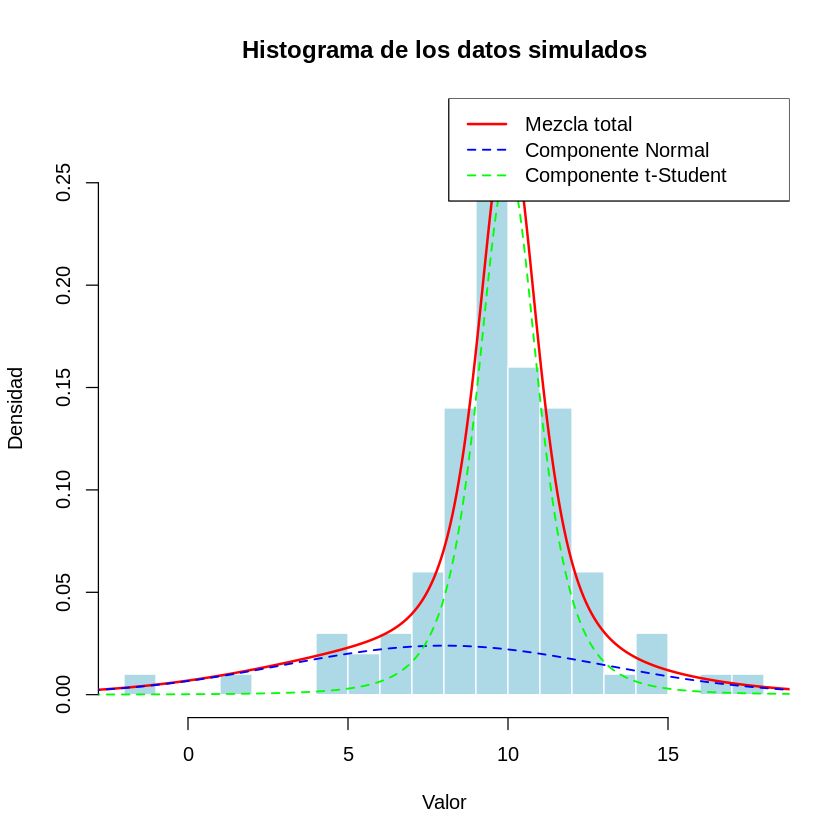

In [7]:
# Visualizar los datos simulados
hist(datos, breaks = 20, freq = FALSE,
     main = "Histograma de los datos simulados",
     xlab = "Valor", ylab = "Densidad",
     col = "lightblue", border = "white")

# Superponer las densidades de las componentes
x_seq <- seq(min(datos) - 5, max(datos) + 5, length.out = 1000)

# Densidad de la mezcla teórica
densidad_mezcla <- function(x, alpha) {
    (1 - alpha) * dnorm(x, mean = 8, sd = 5) +
    alpha * dt((x - 10), df = 3)
}

lines(x_seq, densidad_mezcla(x_seq, alpha_verdadero),
      col = "red", lwd = 2)

# Agregar las componentes individuales
lines(x_seq, (1 - alpha_verdadero) * dnorm(x_seq, mean = 8, sd = 5),
      col = "blue", lty = 2, lwd = 1.5)
lines(x_seq, alpha_verdadero * dt((x_seq - 10), df = 3),
      col = "green", lty = 2, lwd = 1.5)

legend("topright",
       c("Mezcla total", "Componente Normal", "Componente t-Student"),
       col = c("red", "blue", "green"),
       lty = c(1, 2, 2), lwd = c(2, 1.5, 1.5))


## Parte 2: Inferencia Bayesiana con Metropolis-Hastings

Implementar MH para estimar α usando dos prioris diferentes:
- Beta(1, 1) - Uniforme en [0, 1]
- Beta(2, 10) - Favorece valores pequeños de α


In [8]:
# Función de log-verosimilitud
log_verosimilitud <- function(alpha, datos) {
    # Calcular la log-verosimilitud de los datos dada alpha
    log_lik <- 0
    for (y in datos) {
        # Densidad de la mezcla
        dens <- (1 - alpha) * dnorm(y, mean = 8, sd = 5) +
                alpha * dt((y - 10), df = 3)
        log_lik <- log_lik + log(dens)
    }
    return(log_lik)
}

# Función de log-posterior (proporcional)
log_posterior <- function(alpha, datos, a_prior, b_prior) {
    if (alpha <= 0 || alpha >= 1) return(-Inf)

    # Log-prior Beta(a, b)
    log_prior <- (a_prior - 1) * log(alpha) + (b_prior - 1) * log(1 - alpha)

    # Log-verosimilitud
    log_lik <- log_verosimilitud(alpha, datos)

    return(log_prior + log_lik)
}

# Algoritmo Metropolis-Hastings
mh_alpha <- function(n_iter, alpha_inicial, datos, a_prior, b_prior, sigma_prop = 0.05) {
    cadena <- numeric(n_iter)
    cadena[1] <- alpha_inicial
    n_aceptadas <- 0

    for (t in 2:n_iter) {
        # Propuesta: caminata aleatoria en escala logit
        logit_actual <- log(cadena[t-1] / (1 - cadena[t-1]))
        logit_propuesta <- rnorm(1, mean = logit_actual, sd = sigma_prop)
        alpha_propuesta <- 1 / (1 + exp(-logit_propuesta))

        # Calcular razón de aceptación
        log_razon <- log_posterior(alpha_propuesta, datos, a_prior, b_prior) -
                     log_posterior(cadena[t-1], datos, a_prior, b_prior)

        # Aceptar o rechazar
        if (log(runif(1)) < log_razon) {
            cadena[t] <- alpha_propuesta
            n_aceptadas <- n_aceptadas + 1
        } else {
            cadena[t] <- cadena[t-1]
        }
    }

    return(list(
        cadena = cadena,
        tasa_aceptacion = n_aceptadas / (n_iter - 1)
    ))
}


In [9]:
# Ejecutar MH para ambas prioris
n_iter <- 20000
periodo_transitorio <- 2000
alpha_inicial <- 0.5

# Prior 1: Beta(1, 1) - Uniforme
cat("Ejecutando MH con prior Beta(1, 1)...\n")
resultado_uniforme <- mh_alpha(n_iter, alpha_inicial, datos,
                               a_prior = 1, b_prior = 1, sigma_prop = 0.3)
cadena_uniforme <- resultado_uniforme$cadena[(periodo_transitorio+1):n_iter]
cat("Tasa de aceptación:", resultado_uniforme$tasa_aceptacion, "\n")

# Prior 2: Beta(2, 10)
cat("\nEjecutando MH con prior Beta(2, 10)...\n")
resultado_beta210 <- mh_alpha(n_iter, alpha_inicial, datos,
                              a_prior = 2, b_prior = 10, sigma_prop = 0.3)
cadena_beta210 <- resultado_beta210$cadena[(periodo_transitorio+1):n_iter]
cat("Tasa de aceptación:", resultado_beta210$tasa_aceptacion, "\n")

# Calcular estimadores puntuales
E_alpha_uniforme <- mean(cadena_uniforme)
E_alpha_beta210 <- mean(cadena_beta210)

cat("\n=== Estimaciones de E[α|y] ===\n")
cat("Prior Beta(1,1):", E_alpha_uniforme, "\n")
cat("Prior Beta(2,10):", E_alpha_beta210, "\n")
cat("Valor verdadero:", alpha_verdadero, "\n")


Ejecutando MH con prior Beta(1, 1)...
Tasa de aceptación: 0.7866393 

Ejecutando MH con prior Beta(2, 10)...
Tasa de aceptación: 0.7101355 

=== Estimaciones de E[α|y] ===
Prior Beta(1,1): 0.781286 
Prior Beta(2,10): 0.6306711 
Valor verdadero: 0.7 


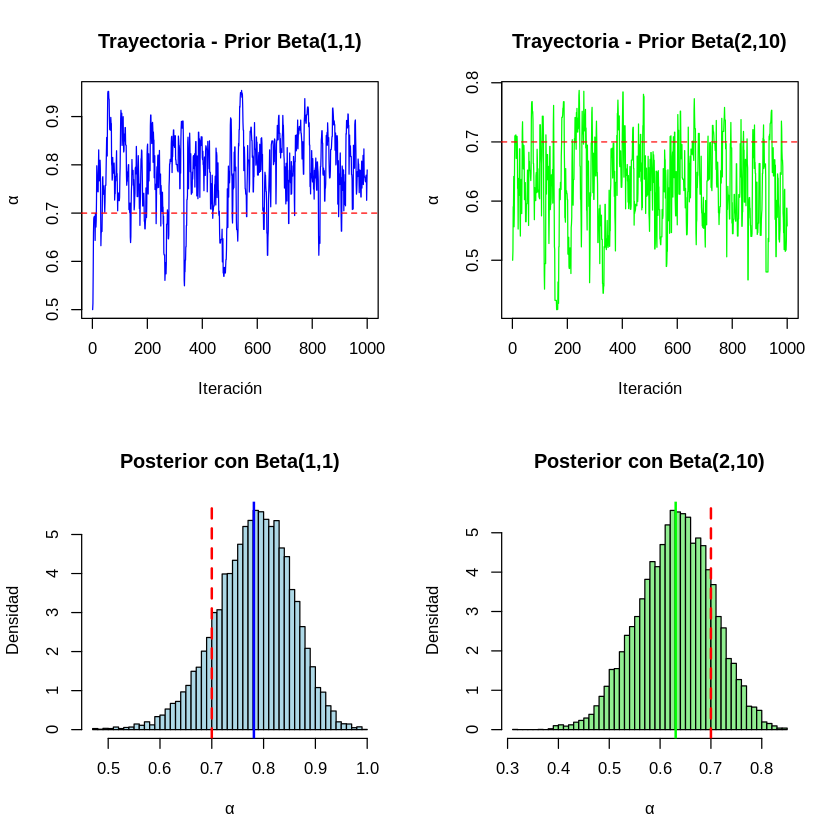

In [10]:
# Visualizar las distribuciones posteriori
par(mfrow = c(2, 2))

# Trayectorias
plot(1:1000, resultado_uniforme$cadena[1:1000], type = "l",
     main = "Trayectoria - Prior Beta(1,1)",
     xlab = "Iteración", ylab = "α", col = "blue")
abline(h = alpha_verdadero, col = "red", lty = 2)

plot(1:1000, resultado_beta210$cadena[1:1000], type = "l",
     main = "Trayectoria - Prior Beta(2,10)",
     xlab = "Iteración", ylab = "α", col = "green")
abline(h = alpha_verdadero, col = "red", lty = 2)

# Histogramas de las posteriori
hist(cadena_uniforme, breaks = 50, freq = FALSE,
     main = "Posterior con Beta(1,1)",
     xlab = "α", ylab = "Densidad", col = "lightblue")
abline(v = alpha_verdadero, col = "red", lty = 2, lwd = 2)
abline(v = E_alpha_uniforme, col = "blue", lty = 1, lwd = 2)

hist(cadena_beta210, breaks = 50, freq = FALSE,
     main = "Posterior con Beta(2,10)",
     xlab = "α", ylab = "Densidad", col = "lightgreen")
abline(v = alpha_verdadero, col = "red", lty = 2, lwd = 2)
abline(v = E_alpha_beta210, col = "green", lty = 1, lwd = 2)

par(mfrow = c(1, 1))


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”



=== Intervalos de credibilidad al 95% ===
Prior Beta(1,1): 0.6258098 0.9120753 
Prior Beta(2,10): 0.485141 0.7671437 


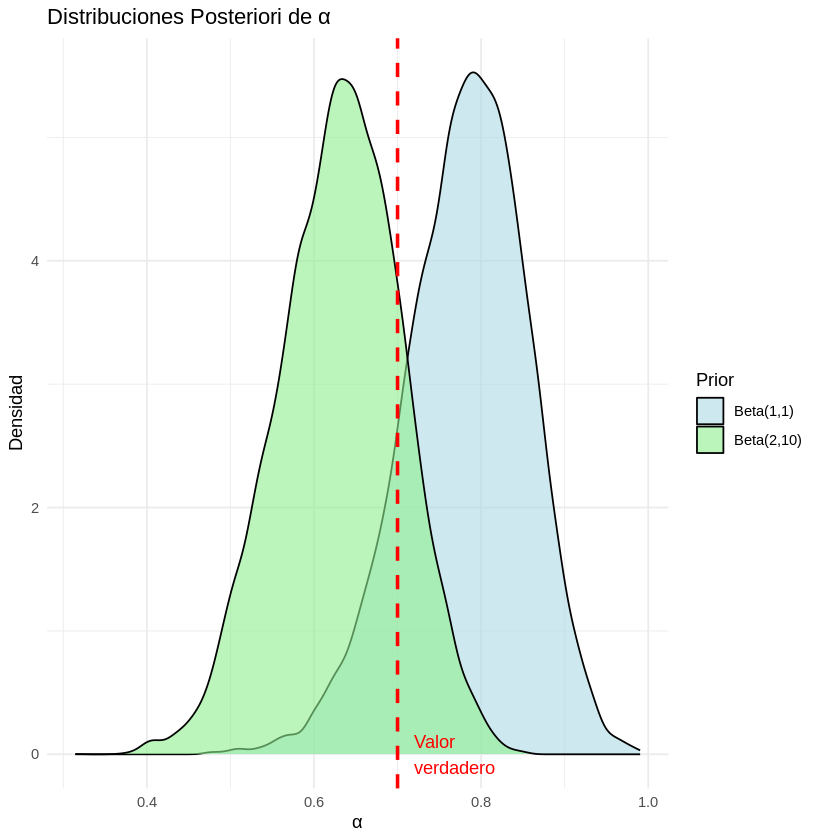

In [11]:
# Comparación de las distribuciones posteriori
# Crear dataframe para ggplot
df_posterior <- data.frame(
    alpha = c(cadena_uniforme, cadena_beta210),
    Prior = factor(rep(c("Beta(1,1)", "Beta(2,10)"),
                      c(length(cadena_uniforme), length(cadena_beta210))))
)

# Gráfico de densidades
p1 <- ggplot(df_posterior, aes(x = alpha, fill = Prior)) +
    geom_density(alpha = 0.6) +
    geom_vline(xintercept = alpha_verdadero, linetype = "dashed", color = "red", size = 1) +
    labs(title = "Distribuciones Posteriori de α",
         x = "α", y = "Densidad") +
    theme_minimal() +
    scale_fill_manual(values = c("lightblue", "lightgreen")) +
    annotate("text", x = alpha_verdadero + 0.02, y = 0,
             label = "Valor\nverdadero", hjust = 0, color = "red")

print(p1)

# Calcular intervalos de credibilidad
cat("\n=== Intervalos de credibilidad al 95% ===\n")
cat("Prior Beta(1,1):", quantile(cadena_uniforme, c(0.025, 0.975)), "\n")
cat("Prior Beta(2,10):", quantile(cadena_beta210, c(0.025, 0.975)), "\n")



=== RESUMEN FINAL ===
Valor verdadero de α: 0.7 

Prior Beta(1,1) (uniforme):
  E[α|y] = 0.781286 
  SD posterior: 0.07269327 

Prior Beta(2,10):
  E[α|y] = 0.6306711 
  SD posterior: 0.0729812 


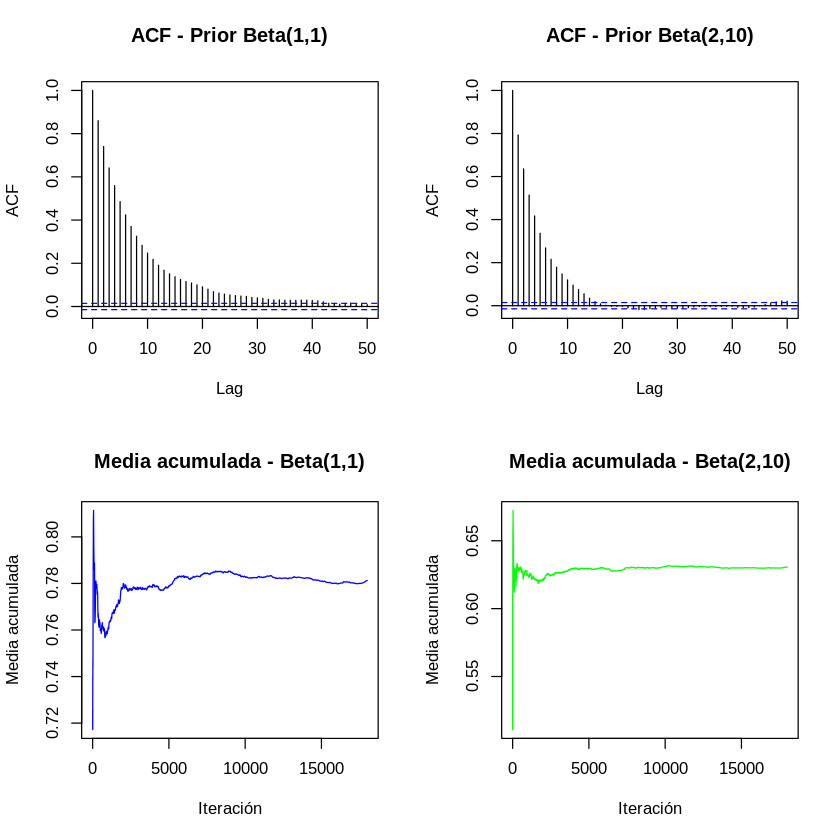

In [12]:
# Análisis de convergencia
par(mfrow = c(2, 2))

# ACF para ambas cadenas
acf(cadena_uniforme, main = "ACF - Prior Beta(1,1)", lag.max = 50)
acf(cadena_beta210, main = "ACF - Prior Beta(2,10)", lag.max = 50)

# Gráficos de medias acumuladas
media_acum_uniforme <- cumsum(cadena_uniforme) / (1:length(cadena_uniforme))
media_acum_beta210 <- cumsum(cadena_beta210) / (1:length(cadena_beta210))

plot(media_acum_uniforme, type = "l", col = "blue",
     main = "Media acumulada - Beta(1,1)",
     xlab = "Iteración", ylab = "Media acumulada")
abline(h = alpha_verdadero, col = "red", lty = 2)

plot(media_acum_beta210, type = "l", col = "green",
     main = "Media acumulada - Beta(2,10)",
     xlab = "Iteración", ylab = "Media acumulada")
abline(h = alpha_verdadero, col = "red", lty = 2)

par(mfrow = c(1, 1))

# Resumen final
cat("\n=== RESUMEN FINAL ===\n")
cat("Valor verdadero de α:", alpha_verdadero, "\n\n")
cat("Prior Beta(1,1) (uniforme):\n")
cat("  E[α|y] =", E_alpha_uniforme, "\n")
cat("  SD posterior:", sd(cadena_uniforme), "\n\n")
cat("Prior Beta(2,10):\n")
cat("  E[α|y] =", E_alpha_beta210, "\n")
cat("  SD posterior:", sd(cadena_beta210), "\n")
